# Monte Carlo Simulation for Option Pricing

This notebook delves into the pricing of options using the Monte Carlo Simulation method. Initially, we cover the background and relevant equations for the process, followed by the implementation of the method in Python. Specifically, we calculate the price of a European call option via Monte Carlo simulation and compare these results with the solution provided by the Black-Scholes formula.

# Content
* [1. Main Idea](#1.-Main-Idea)
* [2. Background](#2.-Background)
* [3. Implementation using Python](#3.-Implementation-using-Python)
* [4. Example European Call Option](#4.-Example-European-Call-Option)
* [5. Compare with the Black Scholes formula](4.-Compare-with-the-Black-Scholes-formula)
* [6. Visualize Geometric Brownian Motion](#6.-Visualize-Geometric-Brownian-Motion)


## 1. Main Idea

Monte Carlo simulation for option pricing involves modeling the future price movements of an underlying asset using stochastic processes, commonly expressed as geometric Brownian motion. Random paths are generated by iteratively applying this process, incorporating increments drawn from a normal distribution. For each simulated path, option payoffs are calculated at expiration, considering the type of option (call or put). These payoffs are then discounted back to present value using the risk-free rate. The Monte Carlo estimate of the option price is obtained by averaging the present values across all simulated paths. This approach provides a flexible and comprehensive way to account for various market conditions and uncertainties, with accuracy improving as the number of simulations increases.

It can be shown that the price of an option $C_0$ is the risk-neutral expectation of ots discounted pay-off. To get an estimate of this using Monte Carlo method, we simulate large number of such discounted pay-offs and then take the average. 

Consider a European option that pays $C_T$ at the maturity date $T$. We simulate the risk neutral processes for the state variables from their values today(time zero) to the maturity date $T$ and compute the pay-off of the contingent claim $C_{T,j}$ for the simulation $j$. Then we discount this pay-off using the simulated short term interest rate sequence. For a constant interest rate $r$ we have

$$C_{0,j} = e^{-rT} C_{T,j}\,.$$

If the simulations are repeated $M$ times, then the estimate of the option price if given by the average of all the outcomes.

$$C_0 = \frac{1}{M} \sum_{j=1}^M C_{0,j} \,.$$ 

To simulate the risk neutral processes for the state variables, we follow the equations given below. 

## 2. Background

Consider an asset with price $S$ that pays out a continuous dividend yield at a rate $\delta$ per annum. If $S$ follows Geometric Brownian Motion (GBM) then it satisfies the Stochastic Differential Equation(SDE): 

$$dS_t = (r-\delta)S_tdt + \sigma S_tdz_t, $$where 

* $dS_t$ - change in the level of the asset price over an interval of time $dt$

* $r$ - continuously compunded risk free interest rate

* $\sigma$ - constant volatility 

* $dz_t$ - Wiener process, $z$ is a random variable

A Weiner process satisfies two properties.

1. $dz_t$ is normally distributed with mean zero and variance $dt$.
2. values of $dz_t$ over two different, non overlapping increments of time are independent. 

Let $x_t = \ln(S_t)$. Then we have,

$$dx_t = \nu dt + \sigma dz_t\,,    \,\,\,\, \nu = r-\delta -\frac{1}{2}\sigma^2\,.$$

Obtaining this equation involved some work using Ito's lemma which we ignore here.

Discretizing the above equation we have 

$$\Delta x = \nu \Delta t + \sigma \Delta z$$\,.

which implies, 

$$x_{t+\Delta t} = x_t +\nu \Delta t + \sigma (z_{t+\Delta t}-z_t)\,.$$

In terms of the asset price $S$ we have,

$$S_{t+\Delta t} = S_t \exp(\nu \Delta t + \sigma (z_{t+\Delta t}-z_t))\,.$$

the random element $z_{t+\Delta t}$ has mean zero and variance $\Delta t$ and it can be simulated by random samples of $\sqrt{\Delta t} \epsilon$, where $\epsilon$ is a sample of standard normal distribution. 

We now divide the time period of $T$ into $N$ intervals and simulate values of $S_t$ at each time step using the above equation. 
Using $S_T$ compute the pay-off $C_T $of the option. For a European call option use $C_T=\max\{0, S_T-K\}$\,.

Repeat the process for large number of such simulations and follow the method explained in the above main idea section to find the estimate for the option price $C_0$.

Reference: 


## 3. Implementation using Python

We implement Monte Carlo simulation method for European Call Option. 

In [404]:
import numpy as np
from scipy.stats import norm


In [405]:
def Monte_Carlo_European_Call(K, T, S, Sig, r, div, N, M):
    """
    ## Inputs
    #K = Strike Price
    #T = Time to maturity in years
    #S = Current stock Price
    # sig = volatility 
    #r = risk free interest rate
    #div = dividend yield
    # N = time steps
    # M = number of simulations
    """
    dt = T/N
    nudt = (r - div - 0.5 * Sig**2) * dt
    sigdt = Sig * np.sqrt(dt)
    lnS = np.log(S)
    
    np.random.seed(123)
    eps = np.random.normal(size=(M, N)) # M(simulations)rows   N(time steps)columns
    nusigma_term = nudt + sigdt * eps
    lnSt = lnS + np.cumsum(nusigma_term, axis = 1) # sum over columns for each of the N rows
    lnSt = lnSt[:,-1] # last column of the matrix has S_T values for each simulation. This is a column vector of N rows
    
    ST = np.exp(lnSt)
    CT = np.maximum(0, ST - K)
    C0 = np.exp(-r*T)*np.sum(CT)/M
    
    
    SD = np.sqrt( (np.sum(CT**2)-(np.sum(CT))**2/M)) / (M-1) 
    SE = SD/np.sqrt(M)
    
    
    print("Call value is ${0} with SE +/- {1}".format(np.round(C0,4),np.round(SE,4)))

## 4. Example European Call Option

In [406]:
# Example usage:

K = 100  # Option strike price
T = 1  # one year    # Time to expiration in years
S = 100  # Current stock price
Sig = 0.2 # Volatility
r = 0.06  # Risk-free interest rate
div = 0.03 # dividend yield
N = 10 # time steps
M = 100000  # number of simulations

In [407]:
Monte_Carlo_European_Call(K, T, S, Sig, r, div, N, M)



Call value is $9.1396 with SE +/- 0.0001


## 5. Compare with the Black Scholes formula

In [408]:
import numpy as np
import matplotlib.pyplot as plt

def black_scholes_call(S, K, T, r, Sig):
    d1 = (np.log(S / K) + (r + 0.5 * Sig**2) * T) / (Sig * np.sqrt(T))
    d2 = d1 - Sig * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [409]:
call_price = black_scholes_call(S, K, T, r, Sig)


print(f"Call Option Price: {call_price:.4f}")


Call Option Price: 10.9895


## 6. Visualize Geometric Brownian Motion

In [412]:
def GBM_paths(T, S, Sig, r, div, N, M):
    """
    Inputs
    #T = Time to maturity in years
    #S = Current stock Price
    # sig = volatility 
    #r = risk free interest rate
    #div = dividend yield
    # N = time steps
    # M = number of simulations
    
    Output
    # [steps,N] Matrix of asset paths 
    """

    dt = T/N
    nudt = (r - div - 0.5 * Sig**2) * dt
    sigdt = Sig * np.sqrt(dt)
    lnS = np.log(S)
    
    np.random.seed(123)
    eps = np.random.normal(size=(N, M)) # M(simulations)rows   N(time steps)columns
    nusigma_term = nudt + sigdt * eps
    lnSt = lnS + np.cumsum(nusigma_term, axis = 0) # # sum over rows for each of the M columns
    
    return np.exp(lnSt)



Text(0.5, 1.0, 'Geometric Brownian Motion')

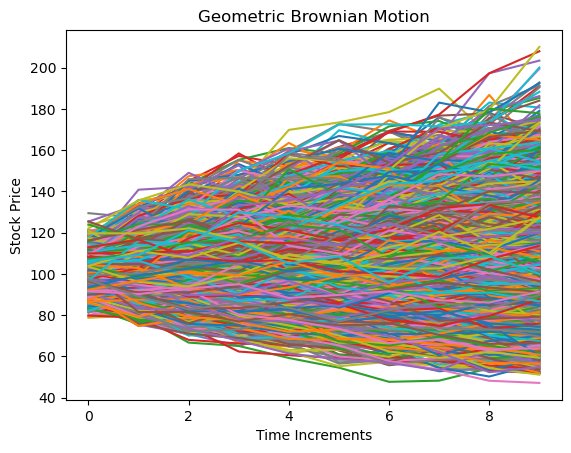

In [416]:
T = 1  # one year    # Time to expiration in years
S = 100  # Current stock price
Sig = 0.2 # Volatility
r = 0.06  # Risk-free interest rate
div = 0.03 # dividend yield
N = 10 # time steps
M = 10000  # number of simulations

paths= GBM_paths(T, S, Sig, r, div, N, M)

plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

Reference: Implementing Derivative Models by Les Clewlow and Chris Strickland